<a href="https://colab.research.google.com/github/bishram-acharya/Cross-Platform-Fingerprint-Matching-using-CNN/blob/main/minor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install pydot

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

In [ ]:
from keras import layers, models
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint


from keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
file_path_to_df = '/content/drive/My Drive/minor_project/final.csv'

In [ ]:
file_path_to_project = '/content/drive/My Drive/minor_project/'

In [ ]:


def vgg16_feature_extractor(input_shape):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage:
input_shape = (224, 224, 3)
vgg16_model = vgg16_feature_extractor(input_shape)
vgg16_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [ ]:
# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Function to build the Siamese network with VGG16
def build_siamese_vgg16(input_shape):
    # Define the input layer for the first image
    input_a = layers.Input(shape=input_shape, name='input_a')
    # Define the input layer for the second image
    input_b = layers.Input(shape=input_shape, name='input_b')

    # Define the VGG16 model (excluding the top layers)
    base_model = vgg16_model


    # Get the output feature vectors from the base model for both inputs
    output_a = base_model(input_a)
    output_b = base_model(input_b)

    # Flatten the output feature vectors
    output_a = layers.Flatten()(output_a)
    output_b = layers.Flatten()(output_b)

    # Compute the L1 distance between the two flattened vectors
    distance = K.abs(output_a - output_b)

    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='output')(distance)

    # Create the Siamese model
    siamese_model = models.Model(inputs=[input_a, input_b], outputs=output, name='siamese_vgg16')

    return siamese_model

# Set the input shape for the VGG16 model
input_shape = (224, 224, 3)

# Build the Siamese VGG16 twins model
learning_rate=0.001
siamese_vgg16 = build_siamese_vgg16(input_shape)
optimizer=Adam(learning_rate=learning_rate)
# Compile the model with contrastive loss
siamese_vgg16.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'], run_eagerly=True)

# Display the model summary
siamese_vgg16.summary()

Model: "siamese_vgg16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_b (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7, 7, 512)            1471468   ['input_a[0][0]',             
                                                          8          'input_b[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 25088)                0         ['sequential[2][0]

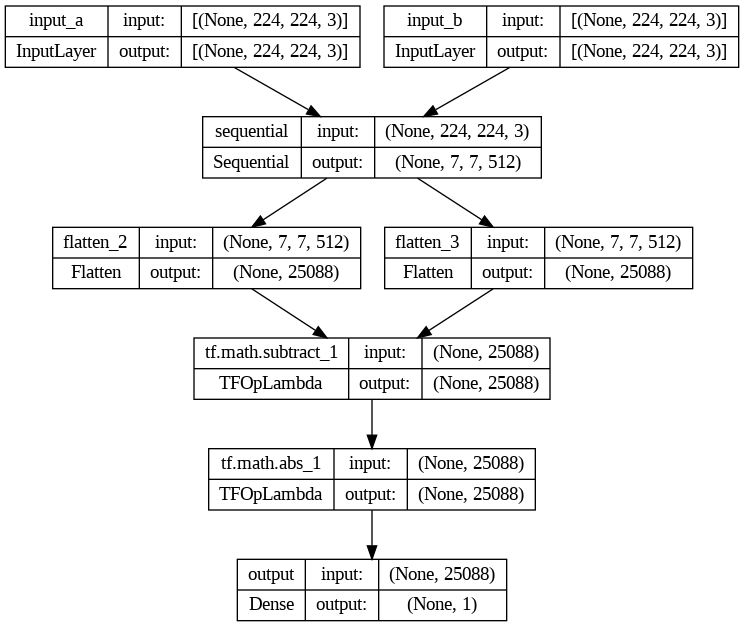

In [ ]:
plot_model(siamese_vgg16, show_shapes=True, show_layer_names=True)


In [ ]:
df = pd.read_csv(file_path_to_df)

In [ ]:
df.head()

,Unnamed: 0,contactbased_path,contactless_path,label
0,0,1_10727_Left_Index.bmp,1_Apple_10727_1_LEFT_image_fingerprint8GIFPDNU...,1
1,1,1_10727_Left_Index.bmp,1_Apple_10727_1_LEFT_image_fingerprint8GIFPDNU...,0
2,2,1_10727_Left_Index.bmp,1_Apple_10727_2_LEFT_image_fingerprint52FCXJQH...,1
3,3,1_10727_Left_Index.bmp,1_Apple_10727_2_LEFT_image_fingerprint52FCXJQH...,0
4,4,1_10727_Left_Index.bmp,1_Apple_10727_3_LEFT_image_fingerprintJ1GFM31O...,1


In [ ]:
# # Load and preprocess the image

# def load_and_preprocess_image_contactbased(path):
#     img = load_img(path, target_size=(224, 224))  # Assuming VGG16 input size
#     img = img_to_array(img) / 255.0  # Normalize pixel values
#     save_img(new_path_contactbased, img)

In [ ]:
# #Contactbased
# n=0
# for filename in os.listdir('/content/drive/My Drive/minor_project/processed_contactbased'):

#   new_path_contactbased=f'/content/drive/My Drive/minor_project/resized_contactbased/{filename}'

#   try:
#     load_and_preprocess_image_contactbased(f'/content/drive/My Drive/minor_project/processed_contactbased/{filename}')
#     n=n+1
#     print(n)
#   except:
#     print("fail")
#     pass

In [ ]:
# # Load and preprocess the image

# def load_and_preprocess_image_contactless(path):
#     img = load_img(path, target_size=(224, 224))  # Assuming VGG16 input size
#     img = img_to_array(img) / 255.0  # Normalize pixel values
#     save_img(new_path_contactless, img)

In [ ]:
# #Contactless
# n=0
# for filename in os.listdir('/content/drive/My Drive/minor_project/processed_contactless'):

#   new_path_contactless=f'/content/drive/My Drive/minor_project/resized_contactless/{filename}'

#   try:
#     load_and_preprocess_image_contactless(f'/content/drive/My Drive/minor_project/processed_contactless/{filename}')
#     n=n+1
#     print(n)
#   except:
#     print("fail")
#     pass

In [ ]:


def data_generator(df, batch_size=32):
    num_samples = len(df)
    while True:
        # Shuffle the DataFrame for each epoch
        df_shuffled = df.sample(frac=1)
        for offset in range(0, num_samples, batch_size):
            batch_df = df_shuffled.iloc[offset:offset+batch_size]
            # Load and preprocess images for this batch
            contact_based_images = []
            contactless_images = []
            labels = []
            for index, row in batch_df.iterrows():
                try:
                  contact_based_img = load_img('/content/drive/My Drive/minor_project/resized_contactbased/' + row['contactbased_path'])
                  contactless_img = load_img('/content/drive/My Drive/minor_project/resized_contactless/'+ row['contactless_path'])
                  label = row['label']
                  contact_based_images.append(contact_based_img)
                  contactless_images.append(contactless_img)
                  labels.append(float(label))
                except FileNotFoundError:
                    print(f"File not found: {row['contactbased_path']} or {row['contactless_path']}. Skipping...")
                    continue
            # Convert lists to NumPy arrays
            contact_based_images = np.array(contact_based_images)
            contactless_images = np.array(contactless_images)
            labels = np.array(labels)
            yield [contact_based_images, contactless_images], labels




df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)


# Define batch size and number of epochs
batch_size = 32
num_epochs = 10

# Create train and validation generators
train_generator = data_generator(df_train, batch_size=batch_size)
val_generator = data_generator(df_val, batch_size=batch_size)



In [ ]:
# Fit the model using generators
checkpoint_path = "/content/drive/My Drive/minor_project/model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)
# # Load the model
# siamese_vgg16.load_weights(checkpoint_path)
history=siamese_vgg16.fit(train_generator, steps_per_epoch=len(df_train)//batch_size, epochs=num_epochs, validation_data=val_generator, validation_steps=len(df_val)//batch_size,callbacks=[checkpoint_callback])


Epoch 1/10
  38/1051 [>.............................] - ETA: 18:38 - loss: 0.4811 - accuracy: 0.4811

KeyboardInterrupt: 

In [ ]:
# Extract loss and accuracy values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, num_epochs + 1)

# Plot loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()